# The Louvain Algorithm for Community Detection

## Introduction

The Louvain algorithm is one of the most widely used methods for detecting communities in large networks. Developed by Blondel et al. in 2008, it has become a standard tool in network science due to its:

- **Efficiency**: Near-linear computational complexity
- **Quality**: Produces partitions with high modularity scores
- **Hierarchical detection**: Reveals community structure at multiple scales
- **Versatility**: Works with weighted, directed, and large-scale networks

This tutorial explores the Louvain algorithm both theoretically and through practical examples, making it accessible for students of complex systems and network science.

In [3]:
# Import necessary libraries
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import warnings
warnings.filterwarnings('ignore')

# Set plot parameters for better visualization
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Define a pastel color palette using matplotlib colormap
pastel_cmap = plt.cm.Pastel1

# Helper function for metric calculation
def calculate_metrics(ground_truth, partition):
    """
    Calculate metrics comparing ground truth and detected communities
    
    Parameters:
        ground_truth: Dictionary mapping nodes to their true community
        partition: Dictionary mapping nodes to their detected community
        
    Returns:
        ari: Adjusted Rand Index
        nmi: Normalized Mutual Information
    """
    # Ensure we're comparing the same nodes by using only nodes that appear in both dictionaries
    common_nodes = sorted(set(ground_truth.keys()) & set(partition.keys()))
    
    # Convert dictionaries to lists for sklearn metrics
    ground_truth_list = [ground_truth[node] for node in common_nodes]
    partition_list = [partition[node] for node in common_nodes]
    
    ari = adjusted_rand_score(ground_truth_list, partition_list)
    nmi = normalized_mutual_info_score(ground_truth_list, partition_list)
    
    return ari, nmi

## Understanding the Louvain Algorithm

The Louvain algorithm is a hierarchical community detection method that optimizes modularity through an iterative two-phase process:

### Phase 1: Local Modularity Optimization
- Start with each node in its own community
- For each node i (in random order):
  - Remove i from its current community
  - Place i in the neighboring community that yields the highest modularity gain
  - If no positive gain is possible, keep i in its original community
- Repeat until no further improvement can be made

### Phase 2: Network Aggregation
- Build a new network where:
  - Nodes are the communities found in Phase 1
  - Edge weights between new nodes are the sum of weights between nodes in the corresponding communities
  - Self-loops represent internal connections within communities

### Full Algorithm
- Apply Phase 1 to the initial network
- Apply Phase 2 to create a condensed network
- Repeat Phases 1 and 2 on the condensed network until no further modularity improvement is possible

## Practical Application: Zachary's Karate Club

Let's apply NetworkX's implementation of the Louvain algorithm to Zachary's Karate Club network, a classic benchmark for community detection.

In [4]:
# Load Zachary's Karate Club dataset
G = nx.karate_club_graph()

# Define ground truth communities based on the eventual split of the club
# Node attribute 'club' contains the ground truth: 'Mr. Hi' (0) or 'Officer' (1)
ground_truth = {}
for node in G.nodes():
    club = G.nodes[node]['club']
    ground_truth[node] = 0 if club == 'Mr. Hi' else 1

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Ground truth communities: 'Mr. Hi' and 'Officer'")

Number of nodes: 34
Number of edges: 78
Ground truth communities: 'Mr. Hi' and 'Officer'


In [5]:
# Apply Louvain algorithm for community detection
# Set a random seed for reproducible results
pos = nx.spring_layout(G, seed=42)  # positions for all nodes
communities = list(nx.community.louvain_communities(G, seed=42))

# Create a mapping from nodes to their community IDs
best_partition = {node: i for i, comm in enumerate(communities) for node in comm}

# Calculate modularity of the detected partition
modularity = nx.community.modularity(G, communities)

# Group nodes by community for easier analysis
community_to_nodes = {}
for node, community_id in best_partition.items():
    if community_id not in community_to_nodes:
        community_to_nodes[community_id] = []
    community_to_nodes[community_id].append(node)

# Display results
print(f"Number of communities detected: {len(community_to_nodes)}")
print(f"Modularity: {modularity:.4f}")
print("\nCommunities:")
for community_id, nodes in community_to_nodes.items():
    print(f"Community {community_id+1}: {sorted(nodes)}")

Number of communities detected: 4
Modularity: 0.4266

Communities:
Community 1: [1, 2, 3, 7, 12, 13]
Community 2: [0, 4, 5, 6, 10, 11, 16, 17, 19, 21]
Community 3: [24, 25, 28, 31]
Community 4: [8, 9, 14, 15, 18, 20, 22, 23, 26, 27, 29, 30, 32, 33]


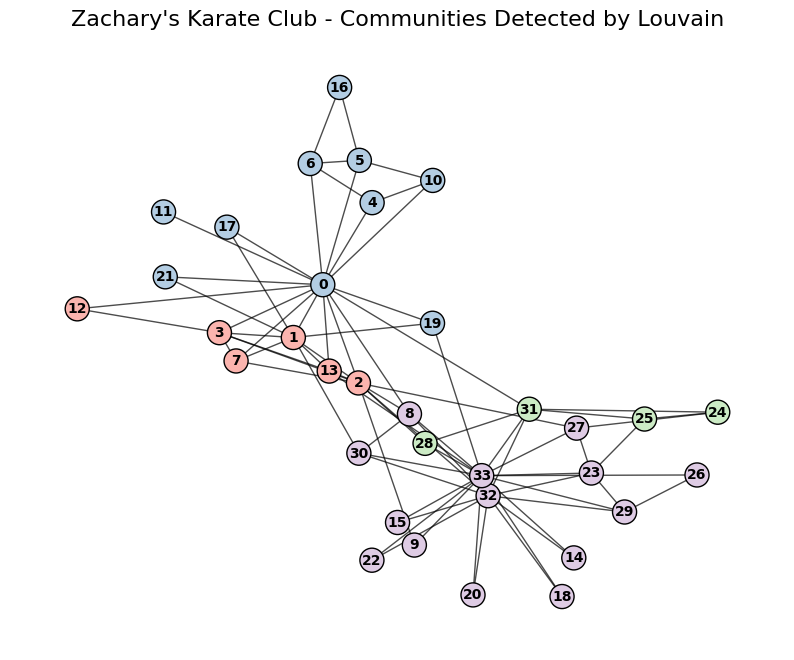

In [6]:
# Visualize the detected communities
plt.figure(figsize=(10, 8))

# Color nodes by their community assignment
colors = [pastel_cmap(best_partition[node] % pastel_cmap.N) for node in G.nodes()]

# Draw the network
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=300, edgecolors='black')
nx.draw_networkx_edges(G, pos, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

plt.title("Zachary's Karate Club - Communities Detected by Louvain", fontsize=16)
plt.axis('off')
plt.show()

## The Effect of Resolution Parameter

The Louvain algorithm implementation in NetworkX includes a **resolution parameter** that controls the scale of detected communities:

- **Lower resolution values** (< 1.0): Favor larger communities
- **Higher resolution values** (> 1.0): Favor smaller communities
- **Default value** (1.0): Standard modularity optimization

This parameter is particularly important for multiscale community detection, allowing researchers to examine structures at different levels of granularity.

In [16]:
def apply_louvain_at_resolution(G, resolution):
    """
    Apply Louvain algorithm with a specific resolution parameter
    
    Parameters:
        G: NetworkX graph
        resolution: Resolution parameter value
        
    Returns:
        partition: Dictionary mapping nodes to community IDs
        modularity: Modularity score of the partition
        communities: List of communities (sets of nodes)
    """
    communities = list(nx.community.louvain_communities(G, resolution=resolution, seed=42))
    partition = {node: i for i, comm in enumerate(communities) for node in comm}
    modularity = nx.community.modularity(G, communities)
    return partition, modularity, communities

# Test different resolution parameters
resolutions = [0.5, 1.0, 5]
results = []

for resolution in resolutions:
    partition, modularity, communities = apply_louvain_at_resolution(G, resolution)
    
    # Count communities
    num_communities = len(communities)
    
    results.append((resolution, num_communities, modularity, partition))
    
    print(f"Resolution: {resolution}, Communities: {num_communities}, Modularity: {modularity:.4f}")

Resolution: 0.5, Communities: 2, Modularity: 0.4036
Resolution: 1.0, Communities: 4, Modularity: 0.4266
Resolution: 5, Communities: 16, Modularity: 0.1771


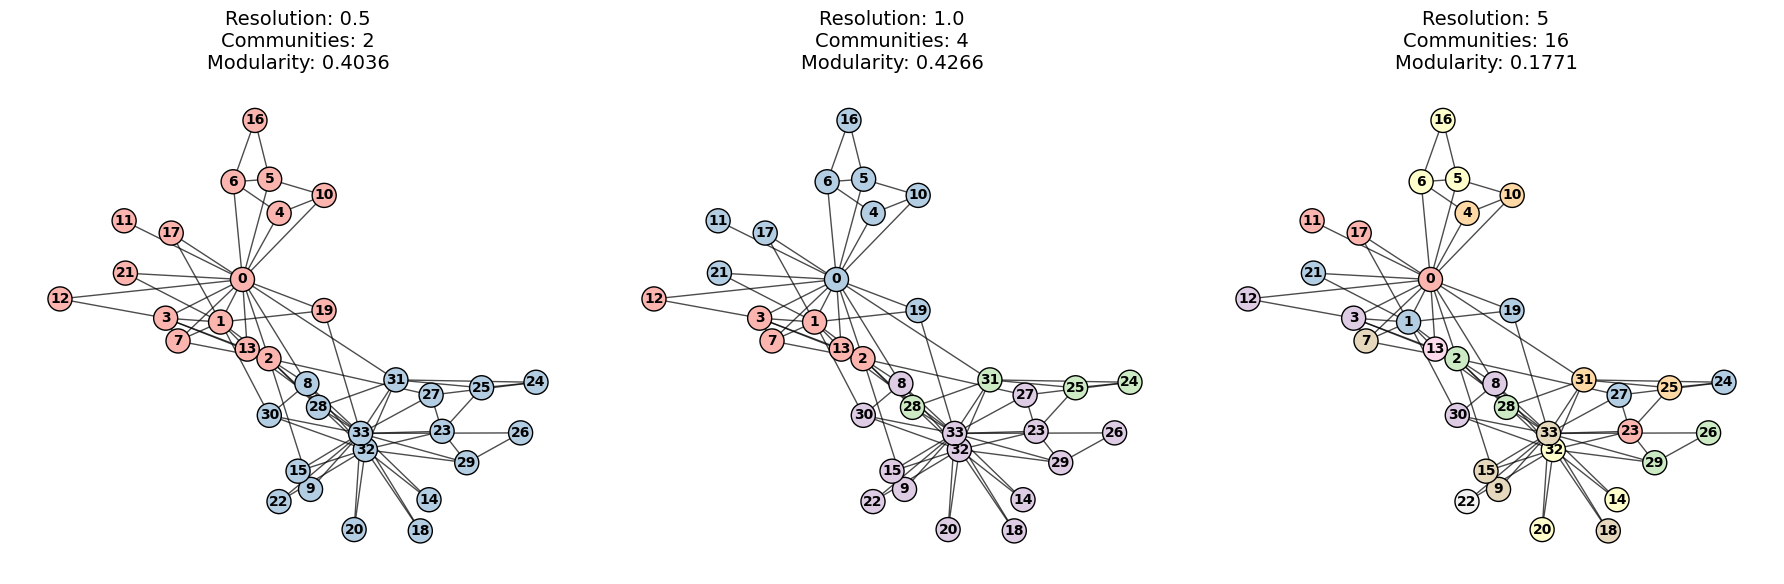

In [17]:
# Visualize results at different resolutions
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (resolution, num_communities, modularity, partition) in enumerate(results):
    ax = axes[i]
    colors = [pastel_cmap(partition[node] % pastel_cmap.N) for node in G.nodes()]
    
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=300, edgecolors='black', ax=ax)
    nx.draw_networkx_edges(G, pos, alpha=0.7, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', ax=ax)
    
    ax.set_title(f"Resolution: {resolution}\nCommunities: {num_communities}\nModularity: {modularity:.4f}", fontsize=14)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Comparing with Ground Truth

How well does the Louvain algorithm recover the "real" community structure? Let's compare the detected communities with the ground truth division of the Karate Club using standard evaluation metrics.

### Evaluation Metrics

1. **Adjusted Rand Index (ARI)**
   - Measures the similarity between two clusterings, adjusted for chance
   - Range: -1 to 1 (1 = perfect agreement, 0 = random chance)

2. **Normalized Mutual Information (NMI)**
   - Measures the mutual dependence between two clusterings
   - Range: 0 to 1 (1 = perfect agreement, 0 = no mutual information)

Comparison with ground truth communities:
------------------------------------------------------------
 Resolution  |  Communities   |   ARI    |   NMI   
------------------------------------------------------------
    0.05     |       1        | 0.0000 | 0.0000
    1.0      |       4        | 0.4905 | 0.5942
     5       |       16       | 0.0798 | 0.3615

Best resolution: 1.0 with ARI: 0.4905


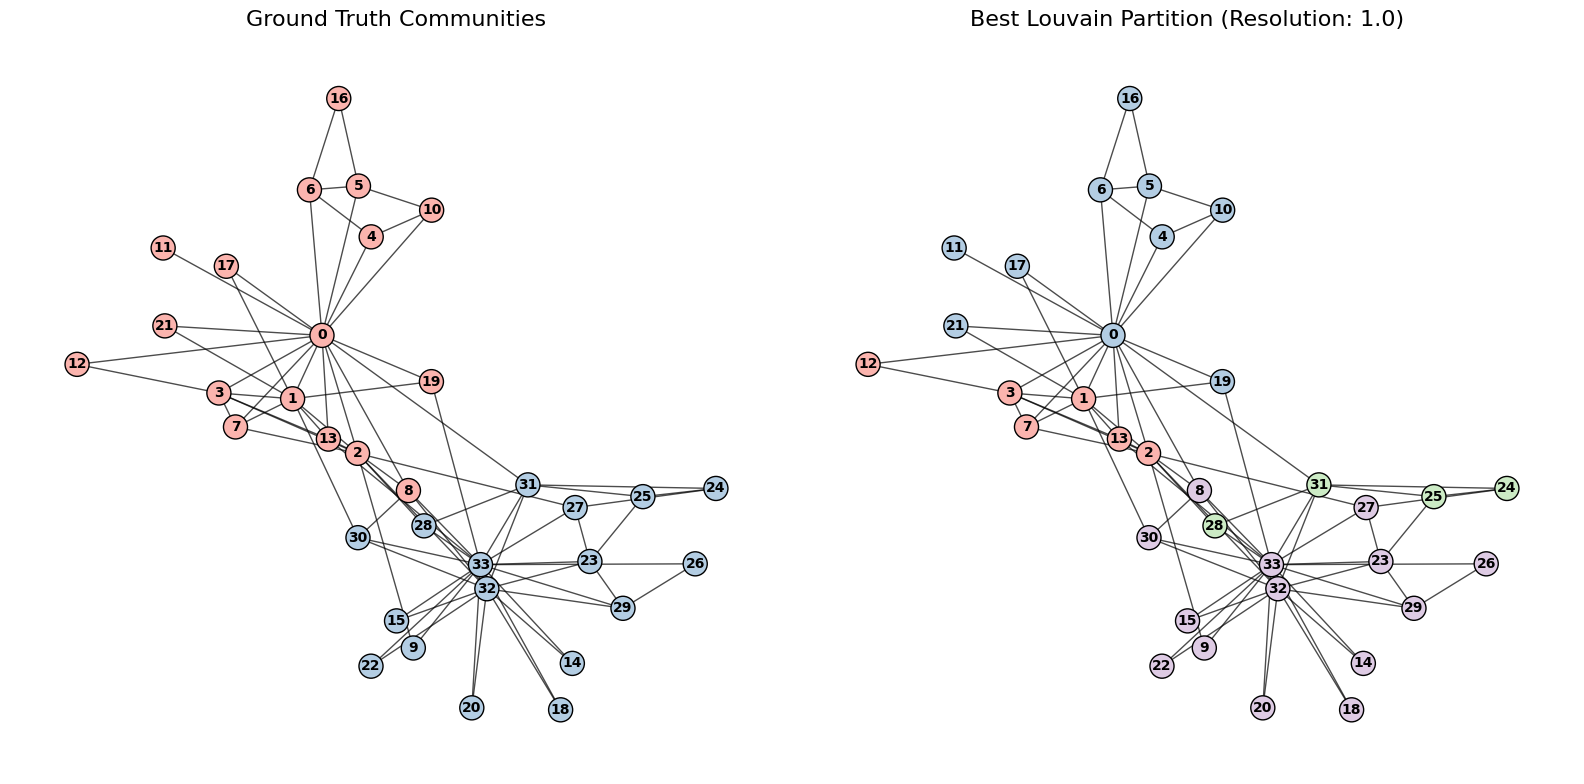

In [9]:
# Analyze each partition against ground truth
print("Comparison with ground truth communities:")
print("-" * 60)
print(f"{'Resolution':^12} | {'Communities':^14} | {'ARI':^8} | {'NMI':^8}")
print("-" * 60)

best_resolution = None
best_ari = -1
best_partition = None

for resolution, num_communities, modularity, partition in results:
    ari, nmi = calculate_metrics(ground_truth, partition)
    print(f"{resolution:^12} | {num_communities:^14} | {ari:.4f} | {nmi:.4f}")
    
    if ari > best_ari:
        best_ari = ari
        best_resolution = resolution
        best_partition = partition

print(f"\nBest resolution: {best_resolution} with ARI: {best_ari:.4f}")

# Visualize ground truth vs. best partition
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Ground truth visualization
colors1 = [pastel_cmap(ground_truth[node]) for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=colors1, node_size=300, edgecolors='black', ax=ax1)
nx.draw_networkx_edges(G, pos, alpha=0.7, ax=ax1)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', ax=ax1)
ax1.set_title("Ground Truth Communities", fontsize=16)
ax1.axis('off')

# Best partition visualization
colors2 = [pastel_cmap(best_partition[node] % pastel_cmap.N) for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=colors2, node_size=300, edgecolors='black', ax=ax2)
nx.draw_networkx_edges(G, pos, alpha=0.7, ax=ax2)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', ax=ax2)
ax2.set_title(f"Best Louvain Partition (Resolution: {best_resolution})", fontsize=16)
ax2.axis('off')

plt.tight_layout()
plt.show()

## Analyzing Misclassified Nodes

When community detection algorithms don't perfectly match ground truth, it's often because some nodes sit at the boundary between communities. Let's identify and analyze these nodes.

### Research Question
Why are certain nodes assigned to communities that differ from the ground truth? Do these nodes have special structural properties?

Number of misclassified nodes: 1
Misclassified nodes: [8]


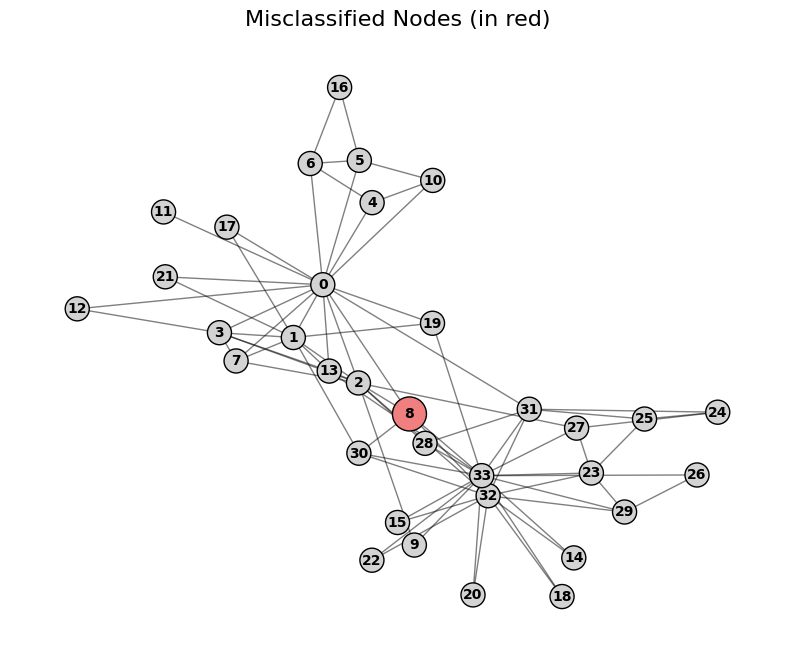

In [10]:
# Map detected communities to ground truth communities
community_to_ground_truth = {}
for node, community in best_partition.items():
    if community not in community_to_ground_truth:
        community_to_ground_truth[community] = []
    community_to_ground_truth[community].append(ground_truth[node])

# Determine the dominant ground truth community for each detected community
dominant_ground_truth = {}
for community, gt_values in community_to_ground_truth.items():
    counts = {0: gt_values.count(0), 1: gt_values.count(1)}
    dominant_ground_truth[community] = max(counts, key=counts.get)

# Find misclassified nodes
misclassified = []
for node, community in best_partition.items():
    expected_gt = dominant_ground_truth[community]
    actual_gt = ground_truth[node]
    if expected_gt != actual_gt:
        misclassified.append(node)

print(f"Number of misclassified nodes: {len(misclassified)}")
print(f"Misclassified nodes: {sorted(misclassified)}")

# Visualize misclassified nodes
plt.figure(figsize=(10, 8))
node_colors = []
for node in G.nodes():
    if node in misclassified:
        node_colors.append('lightcoral')  # Light red for misclassified
    else:
        node_colors.append('lightgray')  # Light grey for correctly classified

node_sizes = [600 if node in misclassified else 300 for node in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, edgecolors='black')
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

plt.title("Misclassified Nodes (in red)", fontsize=16)
plt.axis('off')
plt.show()

## Analyzing the Structural Properties of Misclassified Nodes

Let's examine why certain nodes are misclassified by looking at their topological properties in the network. This analysis helps us understand the relationship between network structure and the performance of community detection algorithms.

### Key Metrics to Examine

- **Connection Patterns**: How many connections does each node have to each ground truth community?
- **Betweenness Centrality**: Do misclassified nodes tend to serve as bridges between communities?
- **Clustering Coefficient**: Are misclassified nodes part of tightly connected groups?

In [11]:
# Calculate topological properties for each node
node_metrics = {}
for node in G.nodes():
    # Calculate number of connections to each ground truth community
    connections_to_0 = sum(1 for neighbor in G.neighbors(node) if ground_truth[neighbor] == 0)
    connections_to_1 = sum(1 for neighbor in G.neighbors(node) if ground_truth[neighbor] == 1)
    
    # Calculate network metrics
    betweenness = nx.betweenness_centrality(G)[node]
    clustering = nx.clustering(G, node)
    
    node_metrics[node] = {
        'degree': G.degree[node],
        'connections_to_0': connections_to_0,
        'connections_to_1': connections_to_1,
        'betweenness': betweenness,
        'clustering': clustering,
        'ground_truth': ground_truth[node],
        'louvain_community': best_partition[node],
        'misclassified': node in misclassified
    }

# Display metrics for misclassified nodes
print("Metrics for misclassified nodes:")
print("-" * 80)
print(f"{'Node':^6} | {'Degree':^6} | {'Connects to C0':^14} | {'Connects to C1':^14} | {'Betweenness':^12} | {'Clustering':^10}")
print("-" * 80)

for node in sorted(misclassified):
    metrics = node_metrics[node]
    ratio0 = metrics['connections_to_0'] / metrics['degree']
    ratio1 = metrics['connections_to_1'] / metrics['degree']
    
    print(f"{node:^6} | {metrics['degree']:^6} | {metrics['connections_to_0']:^5} ({ratio0:.2f}) | {metrics['connections_to_1']:^5} ({ratio1:.2f}) | {metrics['betweenness']:.4f} | {metrics['clustering']:.4f}")

# Analyze boundary nodes (nodes with significant connections to both communities)
boundary_nodes = []
for node, metrics in node_metrics.items():
    ratio0 = metrics['connections_to_0'] / metrics['degree']
    ratio1 = metrics['connections_to_1'] / metrics['degree']
    if min(ratio0, ratio1) > 0.3:  # Significant connections to both communities
        boundary_nodes.append(node)

print(f"\nBoundary nodes (connecting both communities): {sorted(boundary_nodes)}")

Metrics for misclassified nodes:
--------------------------------------------------------------------------------
 Node  | Degree | Connects to C0 | Connects to C1 | Betweenness  | Clustering
--------------------------------------------------------------------------------
  8    |   5    |   2   (0.40) |   3   (0.60) | 0.0559 | 0.5000

Boundary nodes (connecting both communities): [2, 8, 9, 19, 28, 30]


## Resolution Limit Analysis

One key limitation of modularity maximization methods like Louvain is the **resolution limit** - they may fail to detect small communities, even when those communities are well-defined.

### The Resolution Limit Problem

In 2007, Fortunato and Barthélemy demonstrated that modularity optimization cannot detect communities smaller than a certain scale, which depends on the total size of the network and the interconnectedness of communities. Specifically, communities smaller than √(L/2) (where L is the total number of links in the network) may remain undetected, regardless of how strongly connected they are internally.

### Designing a Test Network

To demonstrate this phenomenon, we'll create a synthetic network with:

1. **Multi-scale community structure**: 
   - 6 large communities (5 nodes each)
   - 3 small communities (3 nodes each)

2. **Clear community boundaries**:
   - Each community is a complete graph (clique) where every node connects to every other node
   - Limited connections between communities

3. **Controlled connectivity pattern**:
   - Large communities are connected in a ring structure (each connects only to its neighbors)
   - Small communities each connect to just one large community with a single edge

This design creates a ground truth community structure with communities of different sizes but equally strong internal connectivity. The small communities are intentionally "well-defined" by having complete internal connections but minimal external connections - in theory, they should be easily detectable.

### Purpose of the Experiment

This experiment will demonstrate that:

1. At low resolution values, the Louvain algorithm merges smaller communities with larger ones, even though they are well-defined

2. Only at higher resolution values can the algorithm correctly identify all communities

3. The resolution parameter must be tuned properly to detect communities at different scales

This illustrates why the resolution parameter is crucial when applying modularity-based methods to real-world networks, which often contain communities of widely varying sizes.

In [12]:
# Create a synthetic network with clear community structure at different scales
def create_test_network():
    """
    Create a synthetic network with:
    - 6 large communities (5 nodes each)
    - 3 small communities (3 nodes each)
    - Clear community structure at multiple scales
    """
    G = nx.Graph()
    
    # Create 6 large cliques (5 nodes each) in a ring
    for i in range(6):
        nodes_large = [f"L{i}N{j}" for j in range(5)]
        G.add_nodes_from(nodes_large, community=i, size="large")
        # Make each clique a complete graph
        for u in range(len(nodes_large)):
            for v in range(u+1, len(nodes_large)):
                G.add_edge(nodes_large[u], nodes_large[v])
    
    # Connect the large cliques in a ring
    for i in range(6):
        next_clique = (i + 1) % 6
        G.add_edge(f"L{i}N0", f"L{next_clique}N0")
    
    # Add 3 small cliques (3 nodes each) with weak connections
    for i in range(3):
        nodes_small = [f"S{i}N{j}" for j in range(3)]
        G.add_nodes_from(nodes_small, community=i+6, size="small")
        # Make each small clique a complete graph
        for u in range(len(nodes_small)):
            for v in range(u+1, len(nodes_small)):
                G.add_edge(nodes_small[u], nodes_small[v])
    
    # Connect small cliques to large ones with single edges
    G.add_edge("S0N0", "L0N1")  # Connect small community 0 to large community 0
    G.add_edge("S1N0", "L2N1")  # Connect small community 1 to large community 2
    G.add_edge("S2N0", "L4N1")  # Connect small community 2 to large community 4
    
    # Calculate basic network statistics
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    print(f"Created test network with {num_nodes} nodes and {num_edges} edges")
    print(f"9 ground truth communities: 6 large (5 nodes each) and 3 small (3 nodes each)")
    
    return G

# Create test network
test_network = create_test_network()
test_pos = nx.spring_layout(test_network, seed=42)

Created test network with 39 nodes and 78 edges
9 ground truth communities: 6 large (5 nodes each) and 3 small (3 nodes each)


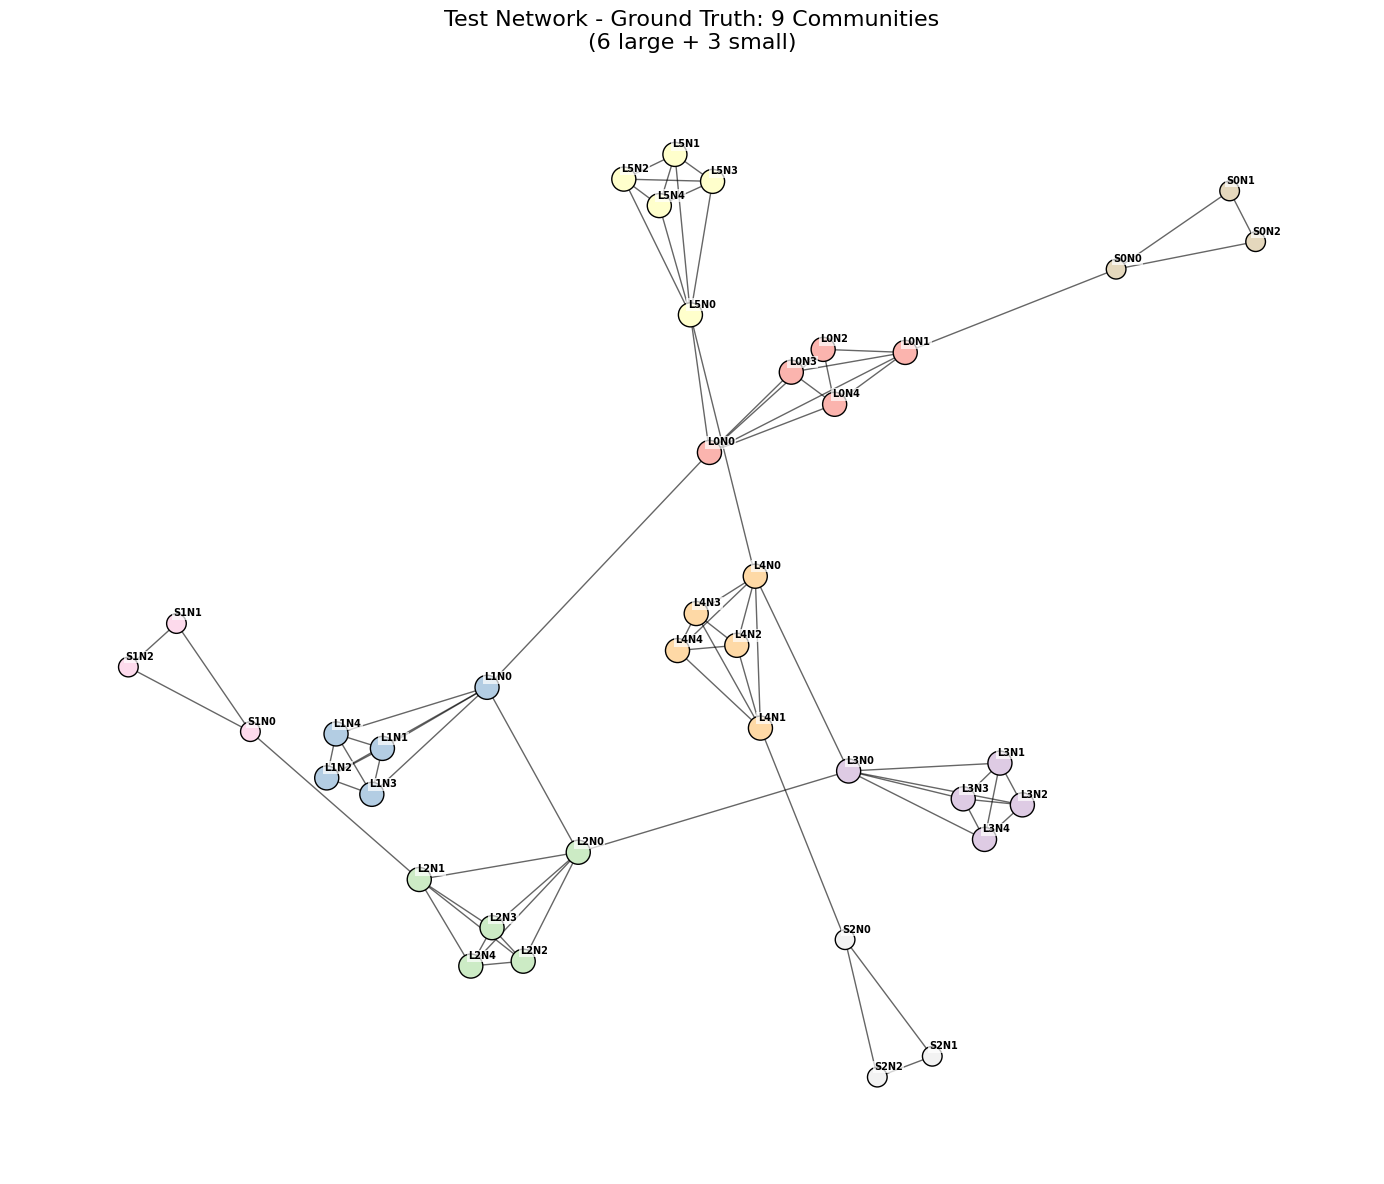

In [13]:
# Visualize the ground truth structure of the test network with improved labels
plt.figure(figsize=(14, 12))

# Color nodes by ground truth community
gt_colors = [pastel_cmap(test_network.nodes[node]['community'] % pastel_cmap.N) for node in test_network.nodes()]
node_sizes = [300 if test_network.nodes[node]['size'] == 'large' else 200 for node in test_network.nodes()]

# Draw nodes and edges
nx.draw_networkx_nodes(test_network, test_pos, node_color=gt_colors, 
                      node_size=node_sizes, edgecolors='black')
nx.draw_networkx_edges(test_network, test_pos, alpha=0.6)

# Create a shifted position dictionary for labels, offset slightly up and right
label_pos = {node: (coords[0] + 0.02, coords[1] + 0.02) 
             for node, coords in test_pos.items()}

# Draw labels with smaller font size and offset position
nx.draw_networkx_labels(test_network, label_pos, font_size=7, font_weight='bold', 
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

plt.title("Test Network - Ground Truth: 9 Communities\n(6 large + 3 small)", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:
# Apply Louvain at different resolutions
resolutions = [0.1, 0.5, 1.0]

# Get ground truth communities
test_ground_truth = {node: test_network.nodes[node]['community'] for node in test_network.nodes()}

# For storing results
results_table = []

# Apply Louvain at different resolutions
for resolution in resolutions:
    # Apply Louvain
    communities = list(nx.community.louvain_communities(test_network, resolution=resolution, seed=42))
    partition = {node: i for i, comm in enumerate(communities) for node in comm}
    modularity = nx.community.modularity(test_network, communities)
    
    # Count communities
    num_communities = len(communities)
    
    # Analyze how many small communities were correctly identified
    small_communities_found = 0
    for comm_id in set(partition.values()):
        nodes_in_comm = [n for n, c in partition.items() if c == comm_id]
        if all(n.startswith('S') for n in nodes_in_comm):
            small_communities_found += 1
    
    # Calculate metrics comparing to ground truth
    ari, nmi = calculate_metrics(test_ground_truth, partition)
    
    # Store results for table
    comm_sizes = [len(comm) for comm in communities]
    results_table.append({
        'resolution': resolution,
        'communities': num_communities,
        'small_found': small_communities_found,
        'min_size': min(comm_sizes),
        'max_size': max(comm_sizes),
        'avg_size': sum(comm_sizes)/len(comm_sizes),
        'ari': ari
    })
    
    print(f"Resolution: {resolution}, Communities: {num_communities}, Small Found: {small_communities_found}/3, ARI: {ari:.4f}")

Resolution: 0.1, Communities: 3, Small Found: 0/3, ARI: 0.3640
Resolution: 0.5, Communities: 6, Small Found: 0/3, ARI: 0.7218
Resolution: 1.0, Communities: 9, Small Found: 3/3, ARI: 1.0000


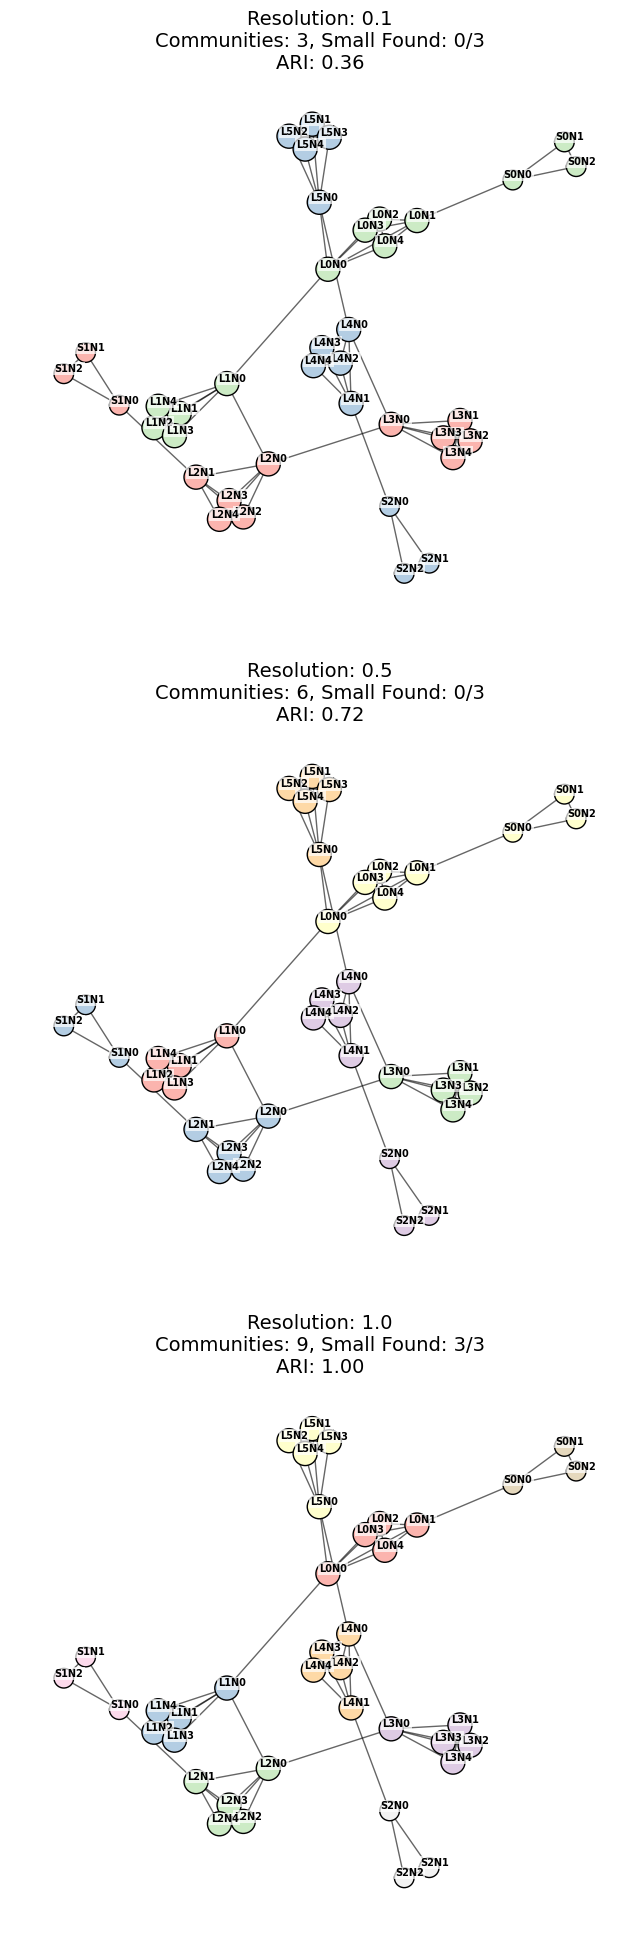

In [15]:
# Visualize the results at different resolutions
fig, axes = plt.subplots(3, 1, figsize=(8, 24))

for i, resolution in enumerate(resolutions):
    ax = axes[i]
    
    # Find the partition for this resolution
    result = next(r for r in results_table if r['resolution'] == resolution)
    
    # Apply Louvain again to get the partition
    communities = list(nx.community.louvain_communities(test_network, resolution=resolution, seed=42))
    partition = {node: i for i, comm in enumerate(communities) for node in comm}
    
    # Visualize nodes and edges
    colors = [pastel_cmap(partition[node] % pastel_cmap.N) for node in test_network.nodes()]
    nx.draw_networkx_nodes(test_network, test_pos, node_color=colors, 
                          node_size=node_sizes, edgecolors='black', ax=ax)
    nx.draw_networkx_edges(test_network, test_pos, alpha=0.6, ax=ax)
    
    # Create a shifted position dictionary for labels
    label_pos = {node: (coords[0] + 0.02, coords[1] + 0.02) 
                for node, coords in test_pos.items()}
    
    # Draw labels with smaller font size, white background for better visibility
    nx.draw_networkx_labels(test_network, label_pos, font_size=7, font_weight='bold', 
                           bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1),
                           ax=ax)
    
    ax.set_title(f"Resolution: {resolution}\nCommunities: {result['communities']}, Small Found: {result['small_found']}/3\nARI: {result['ari']:.2f}", fontsize=14)
    ax.axis('off')

plt.show()

## Conclusion

### Strengths of the Louvain Algorithm

1. **Computational Efficiency**: The Louvain algorithm can process large networks with millions of nodes and edges in reasonable time.

2. **Hierarchical Detection**: The algorithm naturally reveals multilevel community structures through the resolution parameter.

3. **No Predetermined Community Number**: Unlike some clustering algorithms, Louvain automatically determines the appropriate number of communities.

4. **High Quality Results**: Typically produces partitions with high modularity scores that reflect meaningful community structure.

### Limitations

1. **Resolution Limit**: Like other modularity-based methods, Louvain has difficulty detecting communities smaller than a scale dependent on network size.

2. **Degeneracy**: Multiple different partitions may have similar modularity scores, leading to potential instability in results.

3. **Local Optima**: As a greedy algorithm, Louvain may get trapped in local optima rather than finding the global optimum.

### Key Takeaways for Complex Systems Analysis

- The Louvain algorithm balances computational efficiency with detection quality, making it suitable for large-scale network analysis.

- The resolution parameter provides a powerful way to explore communities at different scales, revealing hierarchical structure in complex networks.

- When analyzing real-world networks, compare multiple community detection methods and use domain knowledge to validate results.

- For networks with communities of very different sizes, consider using resolution limit-free methods such as the Leiden algorithm or non-modularity-based approaches.